<a href="https://colab.research.google.com/github/Lewis34cs/fred_alc_beverage_sales/blob/main/time_series_with_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks On Prediction & Evaluation of The Sales of Alcohol 

The link to the dataset can be found here: https://fred.stlouisfed.org/series/S4248SM144NCEN

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

In [3]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# installing FRED's API so we can get access to the target dataset
!pip install fredapi

In [6]:
from fredapi import Fred

In [7]:
# loading api_key from local destination
API_loc = files.upload()

Saving fred_api_key.json to fred_api_key.json


In [8]:
key = API_loc['fred_api_key.json'].decode('utf-8')

In [9]:
# creating an instance of Fred() and feeding in our API key
fred = Fred(api_key=key)

# Retrieving the specific dataset we are wanting to analyze
data = fred.get_series('S4248SM144NCEN')

In [10]:
df = pd.DataFrame(data, index=data.index)
df.head()

,0
1992-01-01,3459.0
1992-02-01,3458.0
1992-03-01,4002.0
1992-04-01,4564.0
1992-05-01,4221.0


In [11]:
len(df)

349

In [12]:
df.isna().sum()

0    0
dtype: int64

Setting column name and the frequency of our index

In [13]:
df.columns = ['Value']

In [14]:
df.index.freq = 'MS'
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01'],
              dtype='datetime64[ns]', length=349, freq='MS')

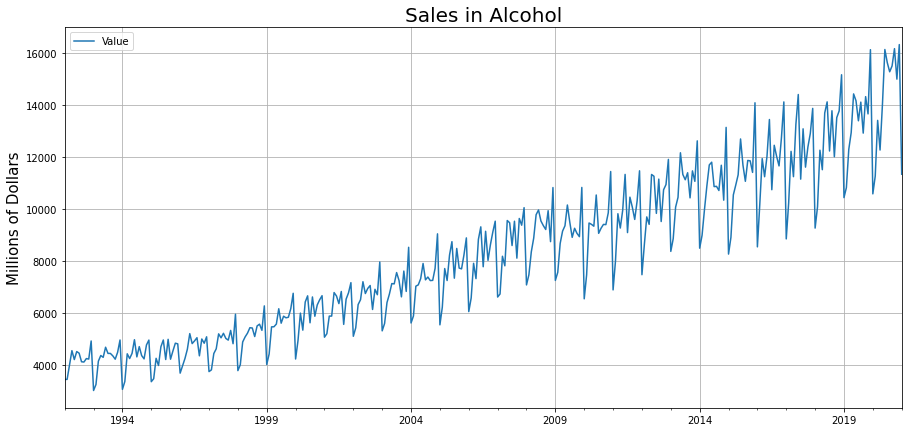

In [15]:
ax = df.plot(figsize=(15, 7), grid=True)
ax.set_title('Sales in Alcohol', fontdict=dict(size=20))
ax.set_ylabel('Millions of Dollars', fontdict=dict(size=15));

Including the 12-month simple moving average 

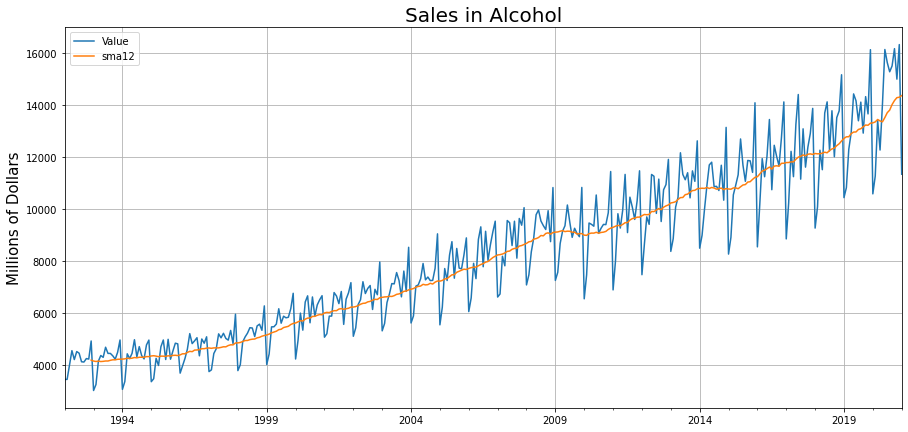

In [16]:
df['sma12'] = df.rolling(12).mean()
ax = df.plot(figsize=(15, 7), grid=True)
ax.set_title('Sales in Alcohol', fontdict=dict(size=20))
ax.set_ylabel('Millions of Dollars', fontdict=dict(size=15));

In [17]:
df.drop(columns='sma12', inplace=True)

In [18]:
season_decomp = seasonal_decompose(df['Value'], model='add')

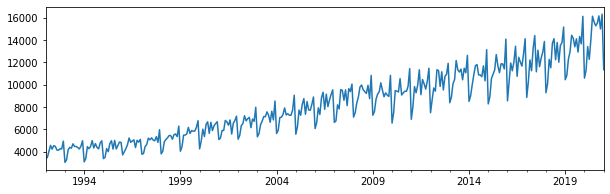

In [19]:
season_decomp.observed.plot(figsize=(10,3));

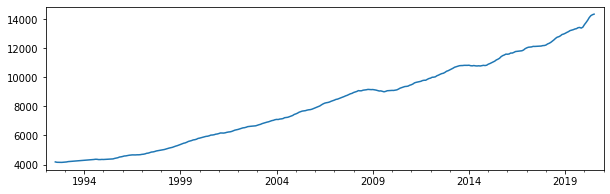

In [20]:
season_decomp.trend.plot(figsize=(10,3));

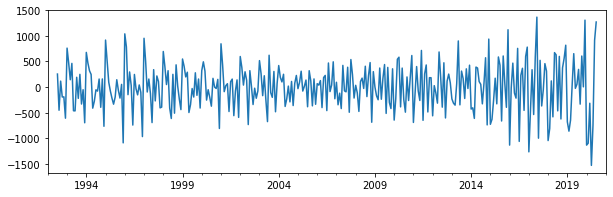

In [21]:
season_decomp.resid.plot(figsize=(10,3));

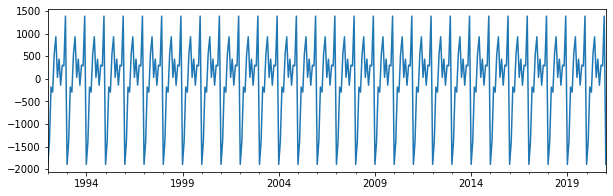

In [22]:
season_decomp.seasonal.plot(figsize=(10,3));

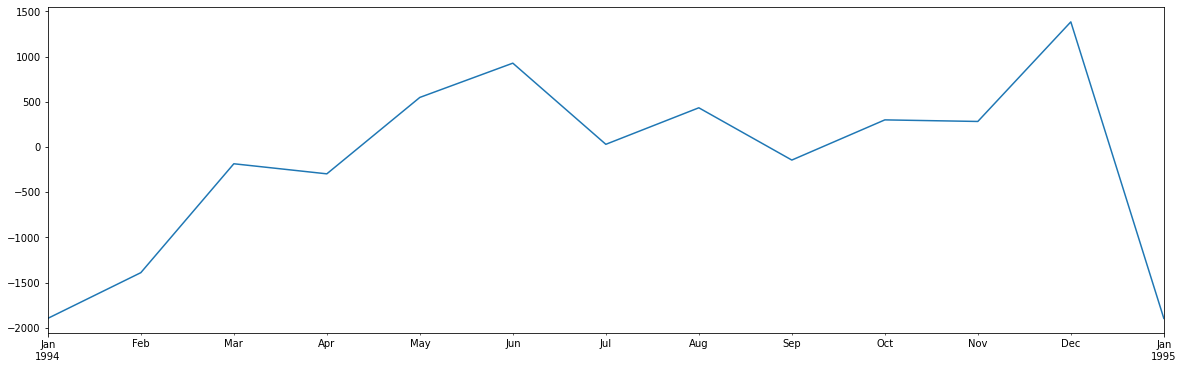

In [23]:
# Magnifying the plot to further inspect the seasonality
season_decomp.seasonal['1994-01-01': '1995-01-01'].plot(figsize=(20,6));

### Creating our Train-test split

In [24]:
# Setting our test set to contain a year's worth of data
NOBS = 24

train = df[['Value']].iloc[:-NOBS]
test = df[['Value']].iloc[-NOBS:]
len(train), len(test)

(325, 24)

In [25]:
# scaling the data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [26]:
scaled_train.shape

(325, 1)

In [27]:
n_feats = scaled_train.shape[1]
length = 12
#creating a time series generator
train_gen = TimeseriesGenerator(scaled_train, scaled_train, length=length, 
                                batch_size=1)

In [28]:
def build_RNN(n_input, n_features, opt='adam', loss='mse', verbose=True):

  model = Sequential()
  model.add(LSTM(150, activation='relu', input_shape=(n_input, n_feats)))

  model.add(Dense(1))
  model.compile(optimizer=opt, loss=loss)
  if verbose:
    print(model.summary())
  return model

In [29]:
rnn01 = build_RNN(n_input=length, n_features=n_feats)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
rnn01.fit(train_gen, epochs=30)

Epoch 1/30
313/313 [==============================] - 7s 15ms/step - loss: 0.0281
Epoch 2/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0090
Epoch 3/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0081
Epoch 4/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0067
Epoch 5/30
313/313 [==============================] - 5s 15ms/step - loss: 0.0084
Epoch 6/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0049
Epoch 7/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0041
Epoch 8/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0032
Epoch 9/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0026
Epoch 10/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0018
Epoch 11/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0017
Epoch 12/30
313/313 [==============================] - 5s 16ms/step - loss: 0.0022
Epoch 13/30
3

Plotting the loss over the number of epochs

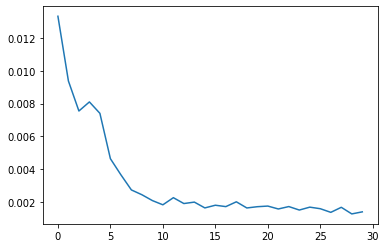

In [31]:
loss_per_epoch = rnn01.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

### Evaluating on our test data

In [32]:
def generate_preds(rnn_model, scaled_train, forecast_len, length, n_features, 
                   inverse=1):

  y_pred = []
  
  first_eval_batch = scaled_train[-length:]
  curr_batch = first_eval_batch.reshape((1, length, n_features))

  for i in range(len(forecast_len)):
    # generating one prediction off of the current batch
    one_pred = rnn_model.predict(curr_batch)[0]
    # adding prediction to our y_pred list
    y_pred.append(one_pred)
    # updating the current batch to remove the oldest datapoint and appending the 
    # one prediction to the end of the batch
    curr_batch = np.append(curr_batch[:,1:,:], [[one_pred]], axis=1)

  # Inverse transforming our predictions to bring back to same value as our test data
  if inverse:
    y_pred = scaler.inverse_transform(y_pred)

  return y_pred

In [33]:
y_pred = generate_preds(rnn01, scaled_train, forecast_len=scaled_test, 
                        length=length, n_features=n_feats)

In [34]:
y_pred

array([[10333.97966129],
       [12228.95097834],
       [11705.53112811],
       [13884.93493927],
       [14122.12962776],
       [12421.73442602],
       [13919.91585058],
       [12161.21623391],
       [13758.54680341],
       [13993.83949763],
       [15314.31803751],
       [10308.48989695],
       [10556.87210572],
       [12174.6402446 ],
       [11908.95835882],
       [14037.81777591],
       [14117.49736303],
       [12611.2141813 ],
       [14049.44043076],
       [12320.90483618],
       [13999.97699499],
       [14197.41804802],
       [15458.31210983],
       [10210.7417261 ]])

adding a new column to our test set

In [36]:
test['Predictions'] = y_pred

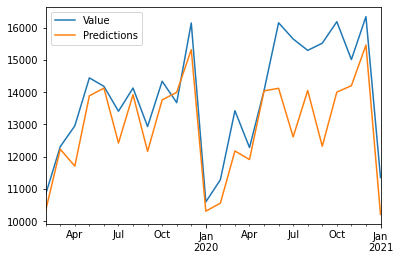

In [37]:
test.plot()

In [38]:
rmse = sqrt(mean_squared_error(test['Value'], test['Predictions']))

In [39]:
rmse

1286.9784635049807

In [40]:
test['Value'].describe()

count       24.000000
mean     13852.000000
std       1767.061304
min      10596.000000
25%      12777.000000
50%      14086.500000
75%      15348.750000
max      16339.000000
Name: Value, dtype: float64

### Predicting into the future



In order to predict into the future, we need to create a dataframe that will contain dates of those predicted dates. Because our data index is arranged by monthly start, we will begin the date range a month after the latest date in the dataset.

In [42]:
forecast_df = pd.DataFrame()

In [43]:
df.index.max()
forecast_df['date'] = pd.date_range(start=df.index.max(), periods=24, freq='MS')

In [46]:
forecast_df['date']

0    2021-01-01
1    2021-02-01
2    2021-03-01
3    2021-04-01
4    2021-05-01
5    2021-06-01
6    2021-07-01
7    2021-08-01
8    2021-09-01
9    2021-10-01
10   2021-11-01
11   2021-12-01
12   2022-01-01
13   2022-02-01
14   2022-03-01
15   2022-04-01
16   2022-05-01
17   2022-06-01
18   2022-07-01
19   2022-08-01
20   2022-09-01
21   2022-10-01
22   2022-11-01
23   2022-12-01
Name: date, dtype: datetime64[ns]

We will make a function that will create a dataframe, the date range for the dataframe, and then place the forecasted values into a new column in that dataframe. 

In [48]:
def forecast(rnn_model, df, forecast_len, length, n_features, freq='MS', inverse=1):
  """
  Definition:
  creates a new dataframe containing the forecasted results based on the forecast_len.

  Args:
  rnn_model: Required. An trained RNN Model
  df: Required. The dataframe to forecast from
  forecast_len: Required. The amount of time to forecast based on the frequency
  length: Required. 
  n_features: default = 1.
  freq: default = 'MS'. The type of freq in the df.index
  inverse: default = 1. If 1, will return inverse transformed values into the
  forecasted dataframe.

  Returns:

  """
  y_pred = []
  forecast_df = pd.DataFrame()
  # Creating a new column in forecast_df that begins the month after the final
  #month in the original df
  forecast_df['date'] = pd.date_range(start=df.index.max()+pd.Timedelta(days=31), 
                                      periods=forecast_len, freq=freq)
  # Scaling the values in our df
  scaler = MinMaxScaler()
  scaled_df = scaler.fit_transform(df)
  # Creating first batch to train off of
  first_eval_batch = scaled_df[-length:]
  # reshaping batch to be equal to the shape of the Timeseries Generator
  curr_batch = first_eval_batch.reshape((1, length, n_features))

  for i in range(forecast_len):
    # generating one prediction off of the current batch
    one_pred = rnn_model.predict(curr_batch)[0]
    # adding prediction to our y_pred list
    y_pred.append(one_pred)
    # updating the current batch to remove the oldest datapoint and appending the 
    # one prediction to the end of the batch
    curr_batch = np.append(curr_batch[:,1:,:], [[one_pred]], axis=1)
  
  # inverse transforming the predicted values so they are back on the same scale as
  # the original values
  if inverse:
    y_pred = scaler.inverse_transform(y_pred)

  # Setting a new column in the forecast_df to include all predicted values
  forecast_df['Value'] = y_pred
  return forecast_df

In [62]:
pred_df = forecast(rnn01, df, 24, length=12, n_features=n_feats)

In [63]:
pred_df.index

RangeIndex(start=0, stop=24, step=1)

In [64]:
pred_df.set_index('date', inplace=True)
pred_df.index.freq = 'MS'

In [65]:
pred_df.head()

,Value
date,
2021-02-01,11554.306915
2021-03-01,13374.462038
2021-04-01,12413.118361
2021-05-01,14403.374457
2021-06-01,16216.703141


In [66]:
df.columns

Index(['Value'], dtype='object')

In [67]:
orig_df = df

In [68]:
pred_df.index

DatetimeIndex(['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

In [69]:
# orig_df.rename(columns={'index': 'date'}, inplace=True)

In [70]:
orig_df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01'],
              dtype='datetime64[ns]', length=349, freq='MS')

In [71]:
total_df = pd.concat([orig_df, pred_df], axis=1)

In [72]:
total_df.columns = ['Value', 'Forecast_Value']

In [73]:
total_df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', length=373, freq='MS')

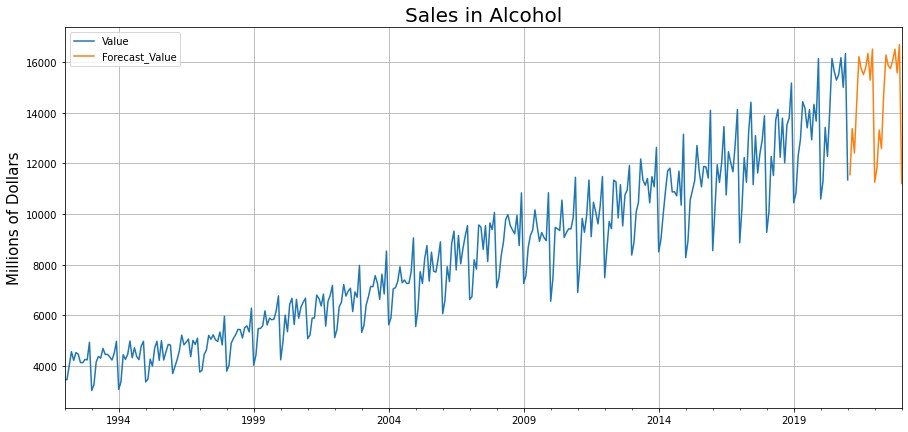

In [74]:
ax = total_df.plot(figsize=(15, 7), grid=True)
ax.set_title('Sales in Alcohol', fontdict=dict(size=20))
ax.set_ylabel('Millions of Dollars', fontdict=dict(size=15));

## Citations:
1. U.S. Census Bureau, Merchant Wholesalers, Except Manufacturers' Sales Branches and Offices Sales: Nondurable Goods: Beer, Wine, and Distilled Alcoholic Beverages Sales [S4248SM144NCEN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/S4248SM144NCEN, March 17, 2021.

In [ ]:
date = df.index.max()+pd.Timedelta(days=31)

In [ ]:
date

Timestamp('2021-02-01 00:00:00', freq='MS')